In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

from phase_space_reconstruction.virtual.beamlines import quadlet_tdc_bend
from phase_space_reconstruction.virtual.scans import run_3d_scan
from phase_space_reconstruction.diagnostics import ImageDiagnostic
from phase_space_reconstruction.visualization import plot_3d_scan_data
from phase_space_reconstruction.train import train_3d_scan

from bmadx.distgen_utils import create_beam
from bmadx.plot import plot_projections
from bmadx.constants import PI

In [2]:
# lattice and data directory
p0c = 43.36e6 # reference momentum in eV/c
lattice = quadlet_tdc_bend(p0c=p0c, dipole_on=False)
data_dir = os.path.join('data', 'yaml_files')

In [3]:
# create gaussian and nongaussian beams using Bmad-X distgen functionality
gaussian_beam = create_beam(
    base_yaml = os.path.join(data_dir,'base.yaml'),
    transforms_yaml = os.path.join(data_dir,'transforms-linear.yaml'), 
    p0c = p0c,
    n_particle = 10_000
    )

nongaussian_beam = create_beam(
    base_yaml = os.path.join(data_dir,'base.yaml'),
    transforms_yaml = os.path.join(data_dir,'transforms-nonlinear.yaml'), 
    p0c = p0c,
    n_particle = 10_000
    )

In [4]:
# create EEX beam
p0c = 10.0e6
data_dir = os.path.join('data','eex_beam')
eex_beam = create_beam(
    base_yaml = os.path.join(data_dir,'base.yaml'),
    transforms_yaml = os.path.join(data_dir,'transforms.yaml'),
    p0c = p0c,
#    save_as = os.path.join('gt_beam.pt'),
    n_particle=10_000
)

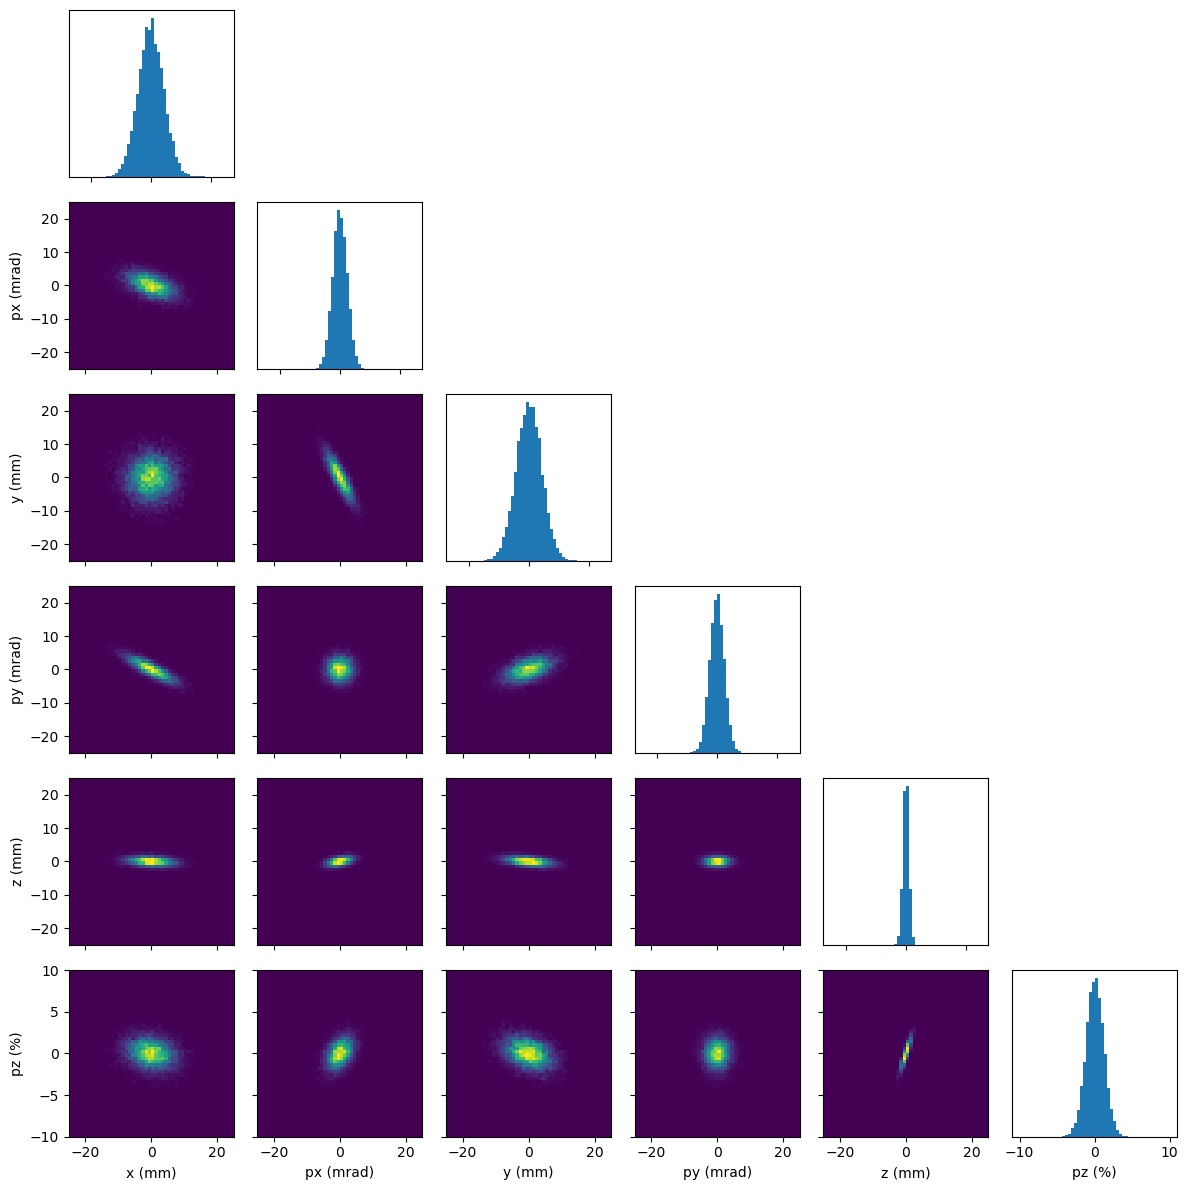

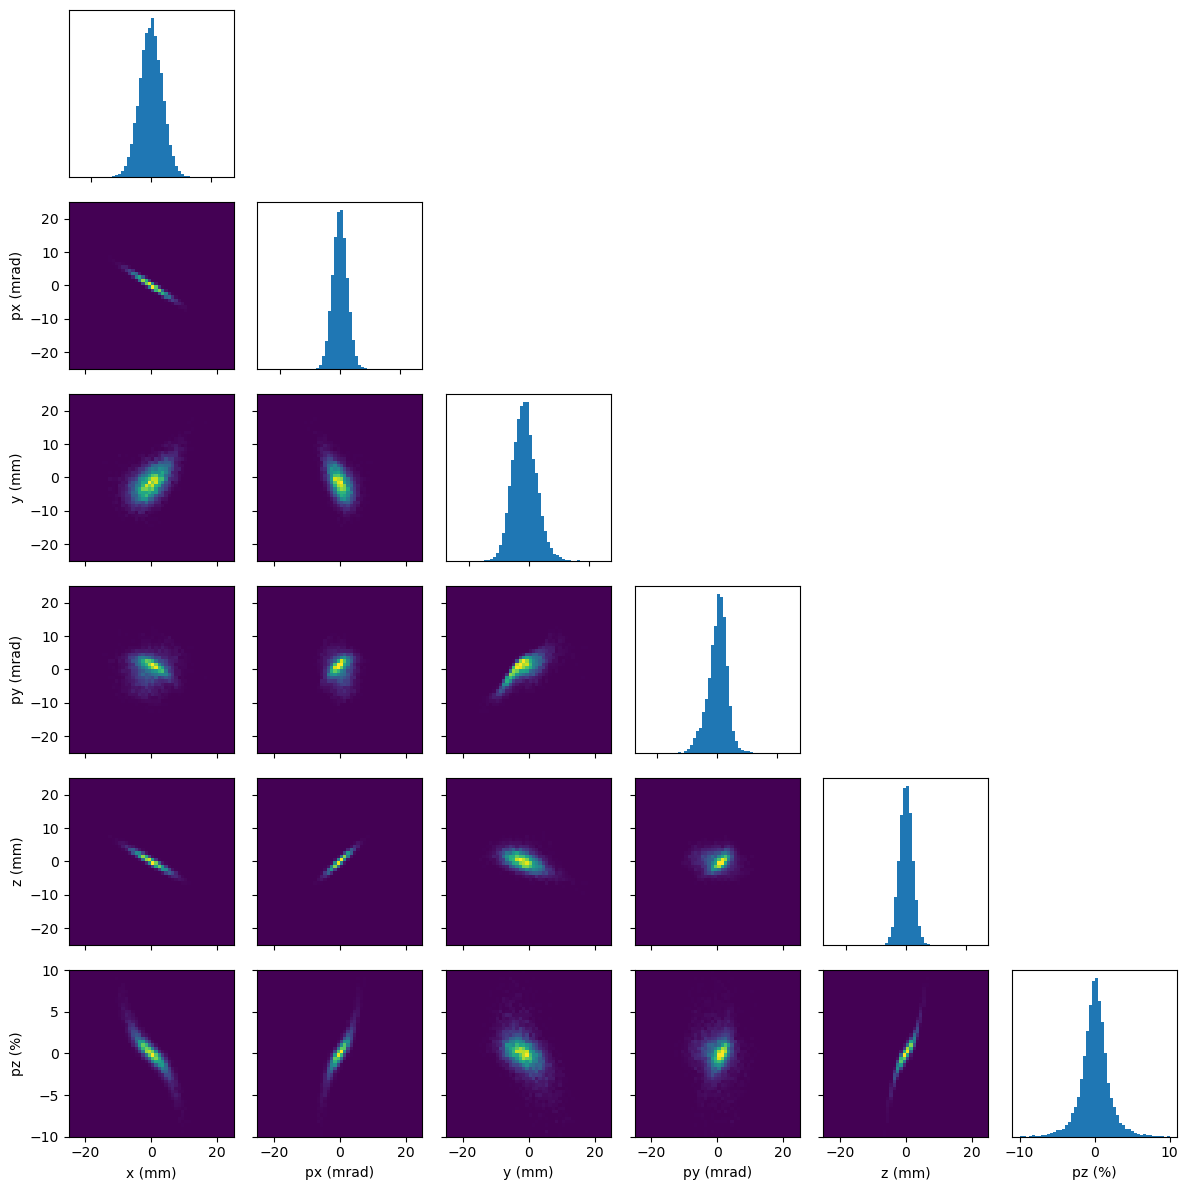

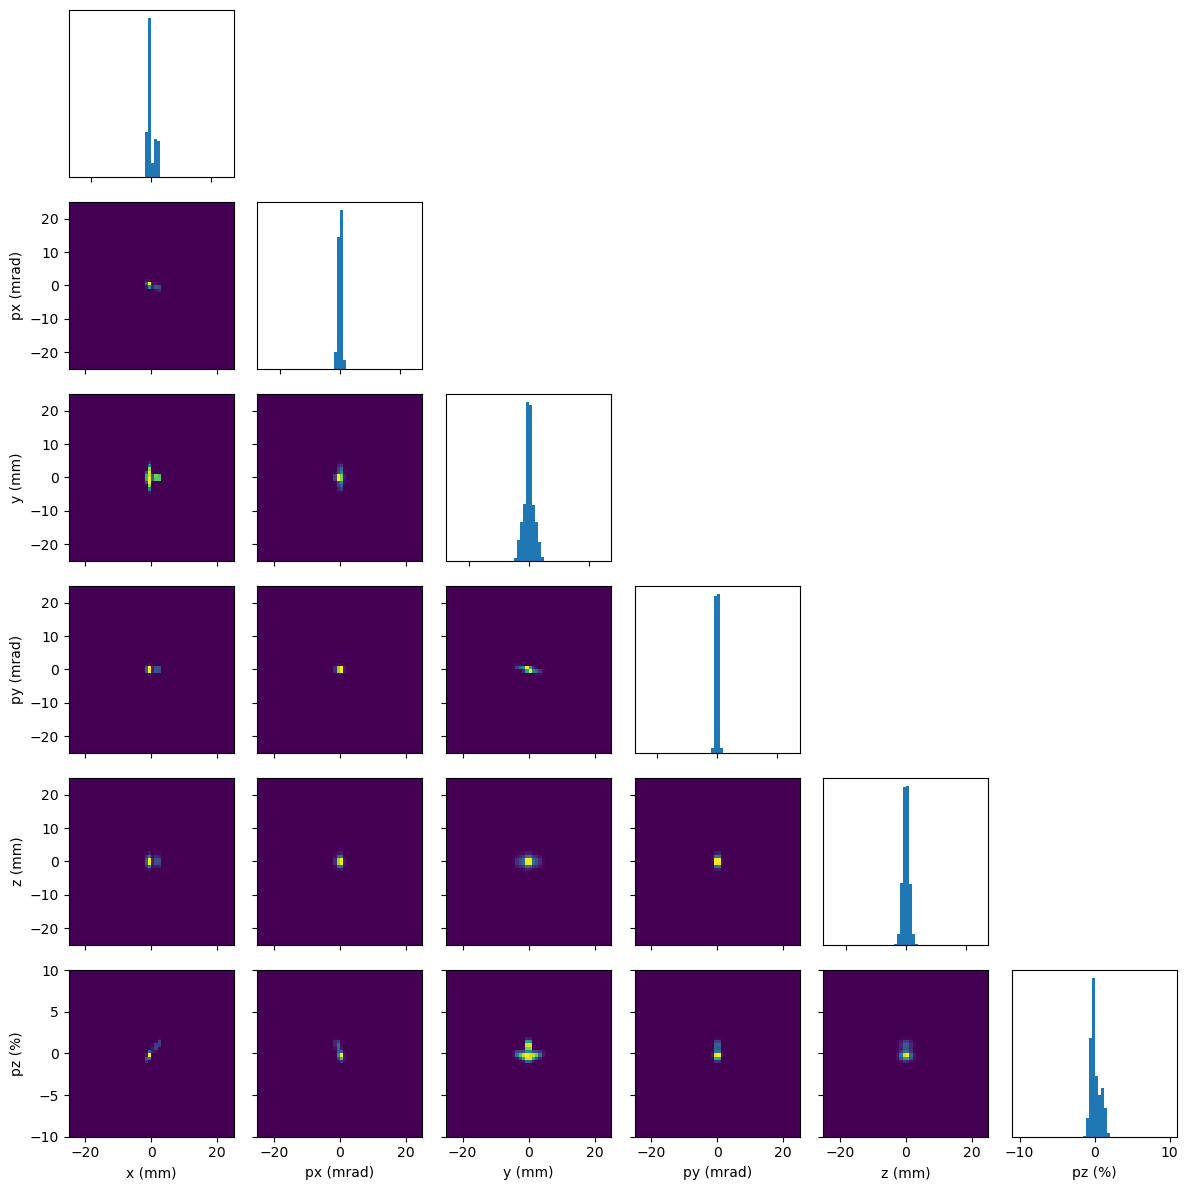

In [5]:
# plot linear and nonlinear beams
lims = np.array(
    [[-25e-3, 25e-3],
     [-25e-3, 25e-3],
     [-25e-3, 25e-3],
     [-25e-3, 25e-3],
     [-25e-3, 25e-3],
     [-10e-2, 10e-2]]
    )
fig, ax = plot_projections(gaussian_beam.numpy_particles(), custom_lims=lims)
plt.show()
fig, ax = plot_projections(nongaussian_beam.numpy_particles(), custom_lims=lims)
plt.show()
fig, ax = plot_projections(eex_beam.numpy_particles(), custom_lims=lims)
plt.show()

In [6]:
# use xopt for optimization
from triplet_opt import optimize_function, output
from xopt import VOCS

opt_vocs = VOCS(
        variables = {"k1":[0,30], "k2":[-30,0], "k3":[0,30]},
        objectives = {"total_size": "MINIMIZE"}
    )

opt_gaussian_beam = optimize_function(
    opt_vocs, output, n_iterations=100, 
    function_kwargs={
        'beam': gaussian_beam,
        'lattice': lattice
    },
    #generator_kwargs={"turbo_controller":"optimize"}
)

opt_nongaussian_beam = optimize_function(
    opt_vocs, output, n_iterations=100, 
    function_kwargs={
        'beam': nongaussian_beam,
        'lattice': lattice
    },
    #generator_kwargs={"turbo_controller":"optimize"}
)

opt_eex_beam = optimize_function(
    opt_vocs, output, n_iterations=100, 
    function_kwargs={
        'beam': eex_beam,
        'lattice': lattice
    },
    #generator_kwargs={"turbo_controller":"optimize"}
)

/global/homes/r/rroussel/.conda/envs/ps-reconstruction/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
# optimization results for linear beam
opt_gaussian_beam.data

,k1,k2,k3,std_x,std_y,total_size,xopt_runtime,xopt_error
0,26.620711,-14.217142,10.989527,0.043855,0.027944,0.052001,0.030862,False
1,16.498965,-4.930617,9.734657,0.016193,0.062202,0.064276,0.029599,False
2,2.983591,-25.839394,1.699589,0.027135,0.039268,0.047731,0.029495,False
3,2.481273,-16.273028,20.958494,0.005896,0.014412,0.015571,0.029460,False
4,15.141496,-20.220009,12.663377,0.030063,0.010348,0.031794,0.029396,False
...,...,...,...,...,...,...,...,...
101,18.537945,-25.550548,26.140139,0.001988,0.002485,0.003182,0.022512,False
102,2.160234,-17.499774,28.961237,0.012150,0.022934,0.025954,0.022863,False
103,1.080379,-11.647510,29.383474,0.016792,0.038950,0.042415,0.022596,False
104,9.068180,-23.454020,25.247832,0.003833,0.004623,0.006005,0.022515,False


In [8]:
opt_gaussian_beam.data.iloc[-1][["k1","k2", "k3"]]

k1    18.537945
k2   -25.550548
k3    26.140139
Name: 105, dtype: object

In [9]:
# optimization results for nonlinear beam
opt_nongaussian_beam.data

,k1,k2,k3,std_x,std_y,total_size,xopt_runtime,xopt_error
0,25.774758,-5.636272,25.974271,0.038378,0.191609,0.195414,0.022454,False
1,9.338426,-14.292312,15.471392,0.010892,0.023986,0.026344,0.022338,False
2,12.124607,-14.237130,23.726386,0.004430,0.056318,0.056492,0.022287,False
3,29.871896,-26.922366,18.224882,0.043569,0.041693,0.060304,0.022324,False
4,19.170744,-16.300477,11.343684,0.034792,0.009923,0.036179,0.022293,False
...,...,...,...,...,...,...,...,...
101,7.761863,-24.130340,26.456077,0.001710,0.005021,0.005304,0.022625,False
102,0.097431,-20.292529,28.451352,0.005482,0.013856,0.014901,0.022824,False
103,29.993842,-23.333628,22.541896,0.010355,0.012016,0.015862,0.022885,False
104,0.502574,-7.600057,3.306581,0.006012,0.006389,0.008772,0.022750,False


In [10]:
opt_nongaussian_beam.data.iloc[-1][["k1","k2", "k3"]]

k1     8.949054
k2   -24.567734
k3     26.13763
Name: 105, dtype: object

In [11]:
# optimization results for linear beam
opt_eex_beam.data

,k1,k2,k3,std_x,std_y,total_size,xopt_runtime,xopt_error
0,21.819422,-7.757013,4.561009,0.012737,0.009431,0.015848,0.022783,False
1,5.574471,-3.553552,28.552722,0.002508,0.021290,0.021437,0.022691,False
2,6.513478,-15.185190,20.030460,0.001636,0.004742,0.005016,0.022650,False
3,25.429537,-5.099853,18.113162,0.002526,0.043748,0.043821,0.022709,False
4,21.647029,-17.616222,4.837639,0.019609,0.008258,0.021277,0.022707,False
...,...,...,...,...,...,...,...,...
101,17.367084,-25.025827,27.364914,0.001322,0.001104,0.001722,0.022731,False
102,9.726005,-21.669524,23.321464,0.001385,0.001139,0.001793,0.022908,False
103,3.226191,-4.605778,13.622606,0.001962,0.007038,0.007306,0.022759,False
104,19.266087,-23.349662,24.774050,0.000508,0.002730,0.002777,0.022753,False


In [12]:
opt_eex_beam.data.iloc[-1][["k1","k2", "k3"]]

k1    10.920691
k2   -23.611429
k3    25.582339
Name: 105, dtype: object

<Axes: >

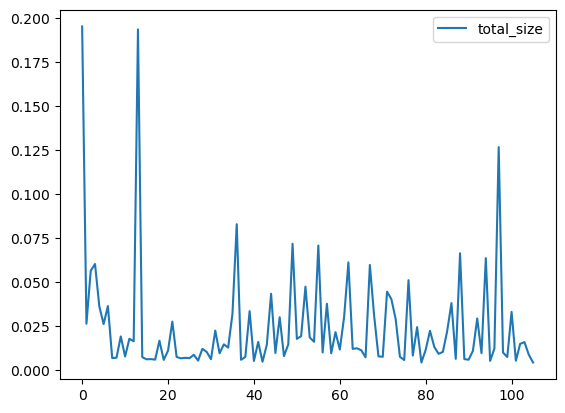

In [13]:
opt_nongaussian_beam.data.plot(y="total_size")